Fingerprinting and Molecular Similarity
> The RDKit has a variety of built-in functionality for generating molecular fingerprints and using them to calculate molecular similarity.

>The most straightforward and consistent way to get fingerprints is to create a FingeprintGenerator object for your fingerprint type of interest and then use that to calculate fingerprints. Fingerprint generators provide a consistent interface to all the supported fingerprinting methods and allow easy generation of fingerprints as:

- bit vectors : fpgen.GetFingerprint
- sparse (unfolded) bit vectors : fpgen.GetSparseFingerprint
- count vectors : fpgen.GetCountFingerprint
- sparse (unfolded) count vectors : fpgen.GetSparseCountFingerprint

Note that there are older, legacy methods of generating fingerprints with the RDKit which are still supported, but these will not be covered here.

In [38]:
from rdkit import DataStructs, Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

In [10]:
ms = [Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO'),Chem.MolFromSmiles('COC')]
fpgen = AllChem.GetRDKitFPGenerator()
fps = [fpgen.GetFingerprint(x) for x in ms]
DataStructs.TanimotoSimilarity(fps[0],fps[1])

0.6

In [11]:
DataStructs.TanimotoSimilarity(fps[0],fps[2])

0.4

In [12]:
DataStructs.TanimotoSimilarity(fps[1],fps[2])

0.25

The examples above used Tanimoto similarity, but one can use different similarity metrics

In [13]:
DataStructs.DiceSimilarity(fps[0],fps[1])

0.75

Available similarity metrics include Tanimoto, Dice, Cosine, Sokal, Russel, Kulczynski, McConnaughey, and Tversky.

More details about the algorithm used for the RDKit fingerprint can be found in the “RDKit Book”.
- The default set of parameters used by the fingerprinter is:
- minimum path size: 1 bond
- maximum path size: 7 bonds
- fingerprint size: 2048 bits
- number of bits set per hash: 2

We can control these when calling AllChem.GetRDKitFPGenerator()

In [14]:
fpgen = AllChem.GetRDKitFPGenerator(maxPath=2,fpSize=1024)
fps = [fpgen.GetFingerprint(x) for x in ms]
DataStructs.TanimotoSimilarity(fps[0],fps[2])

0.5

Atom Pairs and Topological Torsions

Atom-pair descriptors are available in several different forms. The standard form is as fingerprint including counts for each bit instead of just zeros and ones

In [15]:
ms = [Chem.MolFromSmiles('C1CCC1OCC'),Chem.MolFromSmiles('CC(C)OCC'),Chem.MolFromSmiles('CCOCC')]
fpgen = AllChem.GetAtomPairGenerator()
pairFps = [fpgen.GetSparseCountFingerprint(x) for x in ms]

Because the space of bits that can be included in atom-pair fingerprints is huge, they are stored in a sparse manner. We can get the list of bits and their counts for each fingerprint as a dictionary.

In [16]:
pairFps[-1].GetNonzeroElements()

{541732: 1, 558113: 2, 558115: 2, 558146: 1, 1606690: 2, 1606721: 2}

Unlike most other fingerprint types, descriptions of the bits are directly available

In [17]:
from rdkit.Chem.AtomPairs import Pairs
Pairs.ExplainPairScore(558115)

(('C', 1, 0), 3, ('C', 2, 0))

The above means: C with 1 neighbor and 0 pi electrons which is 3 bonds from a C with 2 neighbors and 0 pi electrons

The usual metric for similarity between atom-pair fingerprints is Dice similarity

In [18]:
DataStructs.DiceSimilarity(pairFps[0],pairFps[1])

0.3333333333333333

In [19]:
DataStructs.DiceSimilarity(pairFps[0],pairFps[2])

0.25806451612903225

In [20]:
DataStructs.DiceSimilarity(pairFps[1],pairFps[2])

0.56

It’s also possible to get atom-pair descriptors encoded as a standard bit vector fingerprint.

In [21]:
pairFps = [fpgen.GetFingerprint(x) for x in ms]
DataStructs.DiceSimilarity(pairFps[0],pairFps[1])

0.35294117647058826

In [22]:
DataStructs.DiceSimilarity(pairFps[0],pairFps[2])

0.26666666666666666

In [23]:
DataStructs.DiceSimilarity(pairFps[1],pairFps[2])

0.5833333333333334

By default the atom pair bit vector fingerprints use a scheme which simulates counts in the bit vectors (described in detail in the “RDKit Book”), but this can be disabled

In [24]:
fpgen = AllChem.GetAtomPairGenerator(countSimulation=False)
pairFps = [fpgen.GetFingerprint(x) for x in ms]
DataStructs.DiceSimilarity(pairFps[0],pairFps[1])

0.5

In [25]:
DataStructs.DiceSimilarity(pairFps[0],pairFps[2])

0.4

In [26]:
DataStructs.DiceSimilarity(pairFps[1],pairFps[2])

0.625

Topological torsion descriptors are calculated in essentially the same way

Topological torsion fingerprints, like atom-pair fingerprints, use a count simulation scheme by default when generating bit vector fingerprints

In [27]:
fpgen = AllChem.GetTopologicalTorsionGenerator()
tts = [fpgen.GetSparseCountFingerprint(x) for x in ms]
DataStructs.DiceSimilarity(tts[0],tts[1])

0.16666666666666666

Morgan Fingerprints (Circular Fingerprints)
This family of fingerprints, better known as circular fingerprints, is built by applying the Morgan algorithm to a set of user-supplied atom invariants. When generating Morgan fingerprints, the radius of the fingerprint can also be provided (the default is 3)

In [28]:
fpgen = AllChem.GetMorganGenerator(radius=2)
m1 = Chem.MolFromSmiles('Cc1ccccc1')
fp1 = fpgen.GetSparseCountFingerprint(m1)
fp1

In [29]:
m2 = Chem.MolFromSmiles('Cc1ncccc1')
fp2 = fpgen.GetSparseCountFingerprint(m2)
DataStructs.DiceSimilarity(fp1,fp2)

0.55

Morgan fingerprints, like atom pairs and topological torsions, are often used as counts, but it’s also possible to calculate them as bit vectors, the default fingerprint size is 2048 bits

In [30]:
fp1 = fpgen.GetFingerprint(m1)
fp1

In [31]:
len(fp1)

2048

In [32]:
fp2 = fpgen.GetFingerprint(m2)
DataStructs.DiceSimilarity(fp1,fp2)

0.5185185185185185

The default atom invariants use connectivity information similar to those used for the well known ECFP family of fingerprints. Feature-based invariants, similar to those used for the FCFP fingerprints, can also be used by creating the fingerprint generator with an appropriate atom invariant generator. The feature definitions used are defined in the section Feature Definitions Used in the Morgan Fingerprints. At times this can lead to quite different similarity scores

In [33]:
m1 = Chem.MolFromSmiles('c1ccccn1')
m2 = Chem.MolFromSmiles('c1ccco1')
fpgen = AllChem.GetMorganGenerator(radius=2)
fp1 = fpgen.GetSparseCountFingerprint(m1)
fp2 = fpgen.GetSparseCountFingerprint(m2)
invgen = AllChem.GetMorganFeatureAtomInvGen()
ffpgen = AllChem.GetMorganGenerator(radius=2, atomInvariantsGenerator=invgen)
ffp1 = ffpgen.GetSparseCountFingerprint(m1)
ffp2 = ffpgen.GetSparseCountFingerprint(m2)
DataStructs.DiceSimilarity(fp1,fp2)

0.36363636363636365

In [34]:
DataStructs.DiceSimilarity(ffp1,ffp2)

0.9090909090909091

When comparing the ECFP/FCFP fingerprints and the Morgan fingerprints generated by the RDKit, remember that the 4 in ECFP4 corresponds to the diameter of the atom environments considered, while the Morgan fingerprints take a radius parameter. So the examples above, with radius=2, are roughly equivalent to ECFP4 and FCFP4.

The user can also provide their own atom invariants using the optional customAtomInvariants argument to the GetFingerprint() call. Here’s a simple example that uses a constant for the invariant; the resulting fingerprints compare the topology of molecules

In [35]:
m1 = Chem.MolFromSmiles('Cc1ccccc1')
m2 = Chem.MolFromSmiles('Cc1ncncn1')
fpgen = AllChem.GetMorganGenerator(radius=2)
fp1 = fpgen.GetFingerprint(m1,customAtomInvariants=[1]*m1.GetNumAtoms())
fp2 = fpgen.GetFingerprint(m2,customAtomInvariants=[1]*m2.GetNumAtoms())
fp1==fp2

True

Note that bond order is by default still considered

In [36]:
m3 = Chem.MolFromSmiles('CC1CCCCC1')
fp3 = fpgen.GetFingerprint(m3,customAtomInvariants=[1]*m3.GetNumAtoms())
fp1==fp3

False

But this can also be turned off

In [37]:
fpgen = AllChem.GetMorganGenerator(radius=2,useBondTypes=False)
fp1 = fpgen.GetFingerprint(m1,customAtomInvariants=[1]*m1.GetNumAtoms())
fp3 = fpgen.GetFingerprint(m3,customAtomInvariants=[1]*m3.GetNumAtoms())
fp1==fp3

True

MACCS Keys
There is a SMARTS-based implementation of the 166 public MACCS keys. This is not currently supported by the RDKit’s fingerprint generators, so you have to use a different interface.

In [39]:
ms = [Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO'),
Chem.MolFromSmiles('COC')]
fps = [MACCSkeys.GenMACCSKeys(x) for x in ms]
DataStructs.TanimotoSimilarity(fps[0],fps[1])

0.5

In [40]:
DataStructs.TanimotoSimilarity(fps[0],fps[2])

0.5384615384615384

In [41]:
DataStructs.TanimotoSimilarity(fps[1],fps[2])

0.21428571428571427

Explaining bits from fingerprints
>The fingerprint generators can collect information about the atoms/bonds involved in setting bits when a fingerprint is generated. This information is quite useful for understanding which parts of a molecule were involved in each bit.

>Each fingerprinting method provides different information, but this is all accessed using the additionalOutput argument to the fingerprinting functions.

>Morgan Fingerprints: Information is available about the atoms that contribute to particular bits in the Morgan fingerprint via the bit info map. This is a dictionary with one entry per bit set in the fingerprint, the keys are the bit ids, the values are lists of (atom index, radius) tuples.

In [42]:
m = Chem.MolFromSmiles('c1cccnc1C')
fpgen = AllChem.GetMorganGenerator(radius=2)
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()
fp = fpgen.GetSparseCountFingerprint(m,additionalOutput=ao)
len(fp.GetNonzeroElements())

16

In [43]:
info = ao.GetBitInfoMap()
len(info)

16

In [44]:
info[98513984]

((1, 1), (2, 1))

In [45]:
info[4048591891]

((5, 2),)

Interpreting the above: bit 98513984 is set twice: once by atom 1 and once by atom 2, each at radius 1. Bit 4048591891 is set once by atom 5 at radius 2.

Focusing on bit 4048591891, we can extract the submolecule consisting of all atoms within a radius of 2 of atom 5

In [46]:
env = Chem.FindAtomEnvironmentOfRadiusN(m,2,5)
amap={}
submol=Chem.PathToSubmol(m,env,atomMap=amap)
submol.GetNumAtoms()

6

In [47]:
amap

{0: 0, 1: 1, 3: 2, 4: 3, 5: 4, 6: 5}

And then “explain” the bit by generating SMILES for that submolecule:

In [48]:
Chem.MolToSmiles(submol)

'ccc(C)nc'

This is more useful when the SMILES is rooted at the central atom

In [49]:
Chem.MolToSmiles(submol,rootedAtAtom=amap[5],canonical=False)

'c(cc)(nc)C'

An alternate (and faster, particularly for large numbers of molecules) approach to do the same thing, using the function rdkit.Chem.MolFragmentToSmiles()

In [50]:
atoms=set()
for bidx in env:
    atoms.add(m.GetBondWithIdx(bidx).GetBeginAtomIdx())
    atoms.add(m.GetBondWithIdx(bidx).GetEndAtomIdx())

Chem.MolFragmentToSmiles(m,atomsToUse=list(atoms),bondsToUse=env,rootedAtAtom=5)

'c(C)(cc)nc'

RDKit Fingerprints:
Information is available about the bond paths that contribute to particular bits in the RDKit fingerprint via the bit info map. This is a dictionary with one entry per bit set in the fingerprint, the keys are the bit ids, the values are tuples of tuples containing bond indices.

In [51]:
m = Chem.MolFromSmiles('CCO')
fpgen = AllChem.GetRDKitFPGenerator()
ao = AllChem.AdditionalOutput()
ao.CollectBitPaths()
fp = fpgen.GetSparseCountFingerprint(m,additionalOutput=ao)
len(fp.GetNonzeroElements())

6

In [52]:
paths = ao.GetBitPaths()
len(paths)

6

In [53]:
paths[54413874]

((1,),)

In [54]:
paths[1135572127]

((0, 1),)

In [55]:
paths[1524090560]

((0, 1),)

Those last two examples, which each correspond to the path containing bonds 0 and 1, demonstrate that by default each path sets two bits in the RDKit fingerprint. We can, of course, create a fingerprint generator which does not do this

In [56]:
fpgen = AllChem.GetRDKitFPGenerator(numBitsPerFeature=1)
ao = AllChem.AdditionalOutput()
ao.CollectBitPaths()
fp = fpgen.GetSparseCountFingerprint(m,additionalOutput=ao)
len(fp.GetNonzeroElements())

3

In [57]:
ao.GetBitPaths()

{1524090560: ((0, 1),), 4274652475: ((1,),), 4275705116: ((0,),)}

Here we can also use the bond path information to create submolecules

In [58]:
envs = ao.GetBitPaths()[4274652475]
envs
((1,),)
env = envs[0]
atoms=set()
for bidx in env:
    atoms.add(m.GetBondWithIdx(bidx).GetBeginAtomIdx())
    atoms.add(m.GetBondWithIdx(bidx).GetEndAtomIdx())

Chem.MolFragmentToSmiles(m,atomsToUse=list(atoms),bondsToUse=env)

'CO'

Generating images of fingerprint bits
>For the Morgan and RDKit fingerprint types, it’s possible to generate images of the atom environment that defines the bit using the functions rdkit.Chem.Draw.DrawMorganBit() and rdkit.Chem.Draw.DrawRDKitBit()

In [59]:
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('c1ccccc1CC1CC1')
fpgen = AllChem.GetMorganGenerator(radius=2)
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()
fp = fpgen.GetFingerprint(mol,additionalOutput=ao)
bi = ao.GetBitInfoMap()
bi[872]

((6, 2),)

In [60]:
fp2_svg = Draw.DrawMorganBit(mol, 872, bi, useSVG=True)
fpgen = AllChem.GetRDKitFPGenerator()
ao = AllChem.AdditionalOutput()
ao.CollectBitPaths()
fp = fpgen.GetFingerprint(mol,additionalOutput=ao)
rdkbi = ao.GetBitPaths()
rdkbi[1553]

((0, 1, 9, 5, 4), (2, 3, 4, 9, 5))

In [61]:
rdk_svg = Draw.DrawRDKitBit(mol, 1553, rdkbi, useSVG=True)

Producing these images:

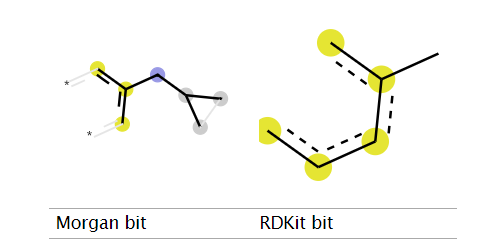

The default highlight colors for the Morgan bits indicate:
- blue: the central atom in the environment
- yellow: aromatic atoms
- gray: aliphatic ring atoms

The default highlight colors for the RDKit bits indicate:
- yellow: aromatic atoms

Note that in cases where the same bit is set by multiple atoms in the molecule (as for bit 1553 for the RDKit fingerprint in the example above), the drawing functions will display the first example. You can change this by specifying which example to show:

In [63]:
rdk_svg = Draw.DrawRDKitBit(mol, 1553, rdkbi, whichExample=1, useSVG=True)

Picking Diverse Molecules Using Fingerprints
> A common task is to pick a small subset of diverse molecules from a larger set. The RDKit provides a number of approaches for doing this in the rdkit.SimDivFilters module. The most efficient of these uses the MaxMin algorithm.  Here’s an example:

Start by reading in a set of molecules and generating Morgan fingerprints:

In [2]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3)
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
with Chem.SDMolSupplier('actives_5ht3.sdf') as suppl:
  ms = [x for x in suppl if x is not None]
fps = [fpgen.GetFingerprint(x) for x in ms]
nfps = len(fps)

Now create a picker and grab a set of 10 diverse molecules:

In [3]:
picker = MaxMinPicker()
pickIndices = picker.LazyBitVectorPick(fps,nfps,10,seed=23)
list(pickIndices)

[93, 137, 135, 109, 18, 150, 142, 12, 6, 160]

Note that the picker just returns indices of the fingerprints; we can get the molecules themselves as follows

In [4]:
picks = [ms[x] for x in pickIndices]

If we aren’t working with bit vector fingerprints, we can also do a diversity pick by providing our own distance matrix to the algorithm. This is less efficient than the above approach, but still works quite quickly:

In [5]:
fps = [fpgen.GetSparseCountFingerprint(x) for x in ms]
def distij(i,j,fps=fps):
  return 1-DataStructs.DiceSimilarity(fps[i],fps[j])
picker = MaxMinPicker()
pickIndices = picker.LazyPick(distij,nfps,10,seed=23)
list(pickIndices)

[93, 109, 154, 6, 95, 135, 151, 61, 137, 139]

Generating Similarity Maps Using Fingerprints
Similarity maps are a way to visualize the atomic contributions to the similarity between a molecule and a reference molecule. The methodology is described in Ref . They are in the rdkit.Chem.Draw.SimilarityMaps module.
Start by creating two molecules:

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

In [12]:
fp = SimilarityMaps.GetAPFingerprint(mol, fpType='normal')
fp = SimilarityMaps.GetTTFingerprint(mol, fpType='normal')
fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')

[16:39:51] DEPRECATION WARNING: please use AtomPairGenerator
[16:39:51] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[16:39:51] DEPRECATION WARNING: please use MorganGenerator


The types of atom pairs and torsions are normal (default), hashed and bit vector (bv). The types of the Morgan fingerprint are bit vector (bv, default) and count vector (count).

The function generating a similarity map for two fingerprints requires the specification of the fingerprint function and optionally the similarity metric. The default for the latter is the Dice similarity. Using all the default arguments of the Morgan fingerprint function, the similarity map can be generated like this

[16:45:30] DEPRECATION WARNING: please use MorganGenerator
[16:45:30] DEPRECATION WARNING: please use MorganGenerator


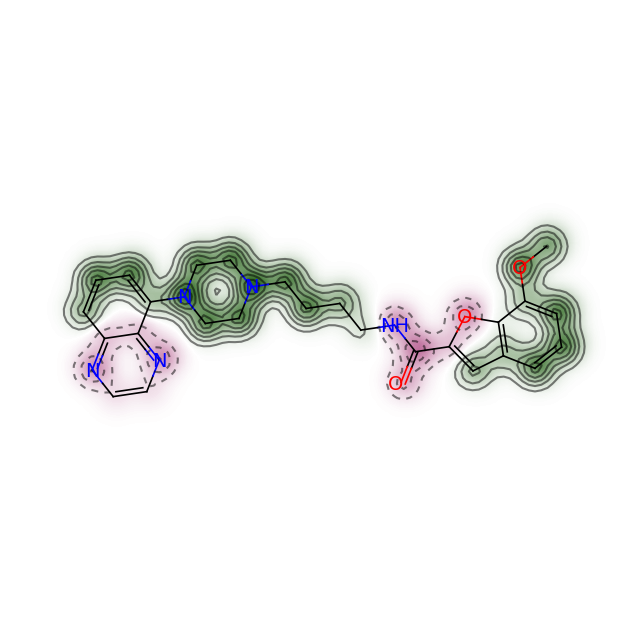

In [22]:

# Define the custom colormap
PiYG_cmap = plt.get_cmap('PiYG', 2)
colorMap = LinearSegmentedColormap.from_list(
    'PiWG', [PiYG_cmap(0), (1.0, 1.0, 1.0), PiYG_cmap(1)], N=255
)
# Generate similarity map with custom color map
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(
    refmol, mol, 
    lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'),
    metric=DataStructs.TanimotoSimilarity,
    colorMap=colorMap  # pass the custom colormap here
)
#Display the figure
plt.show()

For a different type of Morgan (e.g. count) and radius = 1 instead of 2, as well as a different similarity metric (e.g. Tanimoto), the call becomes:

[16:43:31] DEPRECATION WARNING: please use MorganGenerator
[16:43:31] DEPRECATION WARNING: please use MorganGenerator


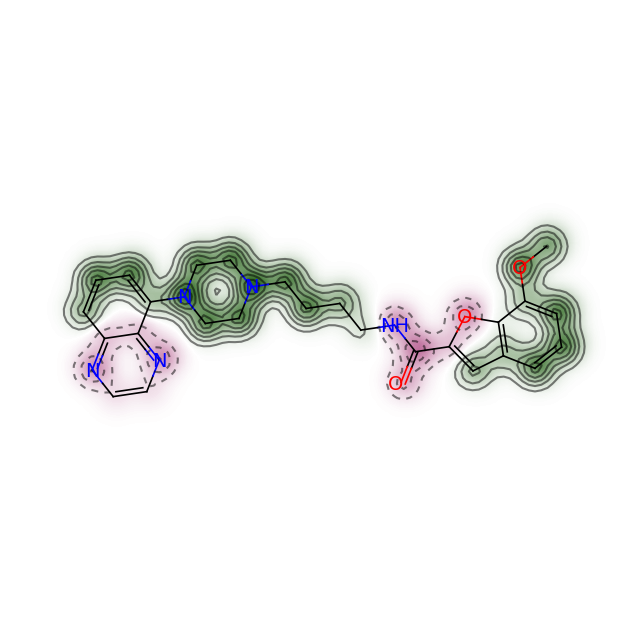

In [17]:
from rdkit import DataStructs
PiYG_cmap = plt.get_cmap('PiYG', 2)
colorMap = LinearSegmentedColormap.from_list(
    'PiWG', [PiYG_cmap(0), (1.0, 1.0, 1.0), PiYG_cmap(1)], N=255
)
# Generate similarity map with custom color map
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(
    refmol, mol, 
    lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'),
    metric=DataStructs.TanimotoSimilarity,
    colorMap=colorMap  # pass the custom colormap here
)

# Show the result
plt.show()

The convenience function GetSimilarityMapForFingerprint involves the normalisation of the atomic weights such that the maximum absolute weight is 1. Therefore, the function outputs the maximum weight that was found when creating the map.

In [18]:
print(maxweight)

0.05747126436781608


If one does not want the normalisation step, the map can be created like:

In [24]:
weights = SimilarityMaps.GetAtomicWeightsForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)
print(["%.2f " % w for w in weights])

['0.05 ', '0.07 ', '0.05 ', '0.08 ', '0.05 ', '0.06 ', '0.03 ', '0.04 ', '-0.01 ', '-0.04 ', '-0.03 ', '-0.05 ', '0.01 ', '0.03 ', '0.07 ', '0.10 ', '0.12 ', '0.11 ', '0.09 ', '0.10 ', '0.09 ', '0.06 ', '0.03 ', '0.02 ', '-0.01 ', '-0.05 ', '0.00 ', '0.00 ', '-0.03 ', '0.02 ', '0.09 ', '0.11 ', '-0.04 ', '0.04 ']


[16:45:44] DEPRECATION WARNING: please use MorganGenerator
[16:45:44] DEPRECATION WARNING: please use MorganGenerator


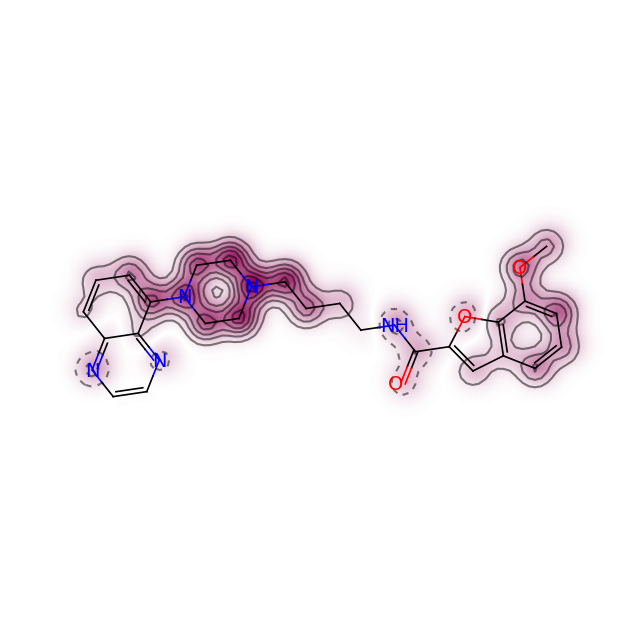

In [27]:
PiYG_cmap = plt.get_cmap('PiYG')
colorMap = LinearSegmentedColormap.from_list(
    'PiYG', [PiYG_cmap(0), (1.0, 1.0, 1.0), PiYG_cmap(1)], N=255
)

# Generate similarity map with custom color map
fig = SimilarityMaps.GetSimilarityMapFromWeights(
    mol, weights, colorMap=colorMap  # Pass the custom colormap here
)
# Show the result
plt.show()